# Romanos NN
Neste notebook vamos treinar uma *Rede Neural* simples para converter números para algarismos romanos.

## Dataset
O dataset é uma tabela contendo **4999** algarismos romanos e seu correspondente em algarismos indo-arábicos.

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
df = pd.read_csv("romanos.csv", sep="\t")
df.head()

,numero,romano
0,1,I
1,2,II
2,3,III
3,4,IV
4,5,V


In [3]:
df.tail()

,numero,romano
4994,4995,MMMMCMXCV
4995,4996,MMMMCMXCVI
4996,4997,MMMMCMXCVII
4997,4998,MMMMCMXCVIII
4998,4999,MMMMCMXCIX


## Preparação dos dados
O primeiro passo para treinar uma rede neural é a preparação de dados. Vamos criar `encodings` para a entrada e a saída dos dados.

A entrada de dados será uma array contendo o valor de cada número em binário (13 bits).

A saída de dados será uma array de 16 bytes contendo a string de saída (128 bits).

In [4]:
df.loc[df["romano"].apply(len).sort_values(ascending=False).index[0]]

numero                4888
romano    MMMMDCCCLXXXVIII
Name: 4887, dtype: object

In [5]:
def encode_in(row):
    R = [int(x) for x in bin(row)[2:]]
    R = [0] * (13 - len(R)) + R
    return R
    
df["in"] = df["numero"].apply(encode_in)
df.head()

,numero,romano,in
0,1,I,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,2,II,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,3,III,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]"
3,4,IV,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,5,V,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]"


In [6]:
def decode_in(row):
    return int("".join([str(x) for x in row]), base=2)
    
df["in"].apply(decode_in)
df["in"].apply(decode_in) == df["numero"]
all(df["in"].apply(decode_in) == df["numero"])

True

In [7]:
def encode_out(row):
    numerais = ["I", "V", "X", "L", "C", "D", "M", " "]
    zeros = np.zeros((16, len(numerais))).astype(np.uint8)
    R = list(row)
    R = [numerais.index(letra) for letra in R]
    R += [len(numerais)-1] * (16 - len(R))
    zeros[np.arange(16), R] = 1
    return zeros.flatten()
    
df["out"] = df["romano"].apply(encode_out)
df.head()

,numero,romano,in,out
0,1,I,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,II,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,III,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,4,IV,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,5,V,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
def decode_out(row):
    numerais = ["I", "V", "X", "L", "C", "D", "M", " "]
    return "".join([numerais[i] for i in row.reshape((16, -1)).argmax(axis=1)]).strip()

df["out"].apply(decode_out)
df["out"].apply(decode_out) == df["romano"]
all(df["out"].apply(decode_out) == df["romano"])

True

Após a preparação dos dados, vamos dividir o dataset em dois conjuntos, o conjunto de treino contendo 80% dos dados e o conjunto de teste contendo 20% dos dados.

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_train = df_train.reset_index().drop(columns="index")
df_test = df_test.reset_index().drop(columns="index")
print("treino:", len(df_train), "teste:", len(df_test))

treino: 3999 teste: 1000


In [10]:
print("conjunto de treino: {} linhas".format(len(df_train)))
df_train.head()

conjunto de treino: 3999 linhas


,numero,romano,in,out
0,884,DCCCLXXXIV,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,344,CCCXLIV,"[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,2500,MMD,"[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,1770,MDCCLXX,"[0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ..."
4,3958,MMMCMLVIII,"[0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [11]:
print("conjunto de teste: {} linhas".format(len(df_test)))
df_test.head()

conjunto de teste: 1000 linhas


,numero,romano,in,out
0,3208,MMMCCVIII,"[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,4994,MMMMCMXCIV,"[1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,3997,MMMCMXCVII,"[0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,2573,MMDLXXIII,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,4184,MMMMCLXXXIV,"[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."


### Importante
- Extrair as características dos dados de entrada e saída;
- Separar os conjuntos de treino e de teste.

## Treinamento

As redes neurais realizam apenas três operações muito simples: 
  - MatMul;
  - Bias Add;
  - ACTIVATE!!!
  
![rede neural](Colored_neural_network.svg)

\begin{align}
\text{MatMul: }& h = W^t\cdotp X \\
\text{Bias Add: }& Z = W^t\cdotp X + b\\
\text{ACTIVATE!: }& A = f(W^t\cdotp X + b)\\
\end{align}

Para treinar uma rede, podemos comparar a saída da rede com a saída esperada e ajustar os pesos da matriz ***W*** e do vetor ***b*** de acordo com os erros. A técnica mais utilizada para isso é o **Backpropagation**.

Além disso, existem *otimizadores* que ajudam a manter a estabilidade do treino, além de diminuir o tempo necessário. Utilizaremos o **Adam** que ajusta alguns hiperparâmetros da rede automaticamente.

![adam](adam.png)

Com os dados prontos, podemos treinar as redes neurais. Vamos começar com uma rede pequena com apenas uma camada oculta:

In [12]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=13))
model.add(Dense(units=128, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
Total params: 9,216
Trainable params: 9,216
Non-trainable params: 0
_________________________________________________________________


A rede neural inicialmente "chuta" qualquer valor para a saída (acurácia ~50%). O texto gerado é aleatório.

In [13]:
def evaluate_model(model, df):
    res = model.evaluate(np.array(df["in"].values.tolist()), np.array(df["out"].values.tolist()))
    print("Custo: {}\nAcurácia: {}".format(*res))
evaluate_model(model, df_test)

1000/1000 [==============================] - 1s 1ms/step
Custo: 0.7031677951812744
Acurácia: 0.498171875


In [14]:
def make_predictions(model, df):
    pred = model.predict(np.array(df["in"].values.tolist()))
    data = []
    for (_, row), p in zip(df.iterrows(), pred):
        _p = decode_out(p)
        data.append({
            "numero": row["numero"],
            "romano": row["romano"],
            "pred": _p,
            "match": row["romano"] == _p
        })
    return pd.DataFrame(data)
def evaluate_algorisms(model, df):
    _df = make_predictions(model, df)
    acertos = _df["match"].sum()
    print(acertos, "acertos", round(acertos/len(_df)*100, 2), "%")
    return _df

df_p0 = evaluate_algorisms(model, df_test)
df_p0.head()

0 acertos 0.0 %


,match,numero,pred,romano
0,False,3208,VDLDLCV CLX MCVC,MMMCCVIII
1,False,4994,VDVVLMV IX XIVD,MMMMCMXCIV
2,False,3997,VDLLCMVCL XXXVVM,MMMCMXCVII
3,False,2573,LX LCMVI CX VMD,MMDLXXIII
4,False,4184,VLVLLCVC LIDVVVD,MMMMCLXXXIV


Treinando o modelo por uma época (todos os ~3999 algarismos) começamos a ver resultados mais coerentes:

In [15]:
history = model.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=1, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 3599 samples, validate on 400 samples
Epoch 1/1
3599/3599 [==============================] - 0s 94us/step - loss: 0.3874 - acc: 0.8669 - val_loss: 0.2048 - val_acc: 0.9292


In [16]:
evaluate_model(model, df_test)

1000/1000 [==============================] - 0s 24us/step
Custo: 0.2024269211292267
Acurácia: 0.929890625


In [17]:
df_p1 = evaluate_algorisms(model, df_test)
df_p1.head()

0 acertos 0.0 %


,match,numero,pred,romano
0,False,3208,MMMCCXX,MMMCCVIII
1,False,4994,MMMMXCX,MMMMCMXCIV
2,False,3997,MMMCCXX,MMMCMXCVII
3,False,2573,MMMCCXXI,MMDLXXIII
4,False,4184,MMMMXC,MMMMCLXXXIV


#### Underfit!!!
Neste caso, o modelo entende a estrutura geral da saída (não separar os algarismos por exemplo), mas ainda não consegue prever os valores corretamente. Dizemos que esse modelo tem um grande viés, e está em regime de **underfit**.


## Treinando mais épocas
Vamos treinar o mesmo modelo por mais 499 épocas:

In [18]:
history = model.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=499, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/499
3599/3599 [==============================] - 0s 61us/step - loss: 0.1871 - acc: 0.9329 - val_loss: 0.1834 - val_acc: 0.9337
Epoch 2/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.1731 - acc: 0.9373 - val_loss: 0.1717 - val_acc: 0.9371
Epoch 3/499
3599/3599 [==============================] - 0s 63us/step - loss: 0.1629 - acc: 0.9397 - val_loss: 0.1623 - val_acc: 0.9395
Epoch 4/499
3599/3599 [==============================] - 0s 62us/step - loss: 0.1553 - acc: 0.9411 - val_loss: 0.1561 - val_acc: 0.9399
Epoch 5/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.1500 - acc: 0.9417 - val_loss: 0.1518 - val_acc: 0.9406
Epoch 6/499
3599/3599 [==============================] - 0s 66us/step - loss: 0.1463 - acc: 0.9421 - val_loss: 0.1483 - val_acc: 0.9413
Epoch 7/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.1434 - acc: 0.9427 - val_loss: 0.1458 - val_acc: 0.9415
E

3599/3599 [==============================] - 0s 66us/step - loss: 0.1061 - acc: 0.9561 - val_loss: 0.1106 - val_acc: 0.9545
Epoch 61/499
3599/3599 [==============================] - 0s 62us/step - loss: 0.1058 - acc: 0.9561 - val_loss: 0.1103 - val_acc: 0.9552
Epoch 62/499
3599/3599 [==============================] - 0s 62us/step - loss: 0.1054 - acc: 0.9564 - val_loss: 0.1102 - val_acc: 0.9547
Epoch 63/499
3599/3599 [==============================] - 0s 63us/step - loss: 0.1051 - acc: 0.9566 - val_loss: 0.1098 - val_acc: 0.9549
Epoch 64/499
3599/3599 [==============================] - 0s 64us/step - loss: 0.1047 - acc: 0.9567 - val_loss: 0.1096 - val_acc: 0.9551
Epoch 65/499
3599/3599 [==============================] - 0s 62us/step - loss: 0.1044 - acc: 0.9567 - val_loss: 0.1093 - val_acc: 0.9555
Epoch 66/499
3599/3599 [==============================] - 0s 63us/step - loss: 0.1041 - acc: 0.9569 - val_loss: 0.1090 - val_acc: 0.9555
Epoch 67/499
3599/3599 [==============================

Epoch 120/499
3599/3599 [==============================] - 0s 58us/step - loss: 0.0920 - acc: 0.9619 - val_loss: 0.0982 - val_acc: 0.9597
Epoch 121/499
3599/3599 [==============================] - 0s 60us/step - loss: 0.0918 - acc: 0.9621 - val_loss: 0.0981 - val_acc: 0.9595
Epoch 122/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.0916 - acc: 0.9622 - val_loss: 0.0977 - val_acc: 0.9596
Epoch 123/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.0914 - acc: 0.9622 - val_loss: 0.0978 - val_acc: 0.9598
Epoch 124/499
3599/3599 [==============================] - 0s 61us/step - loss: 0.0912 - acc: 0.9622 - val_loss: 0.0976 - val_acc: 0.9599
Epoch 125/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.0910 - acc: 0.9625 - val_loss: 0.0975 - val_acc: 0.9596
Epoch 126/499
3599/3599 [==============================] - 0s 62us/step - loss: 0.0909 - acc: 0.9625 - val_loss: 0.0971 - val_acc: 0.9603
Epoch 127/499
3599/3599 [=========

3599/3599 [==============================] - 0s 69us/step - loss: 0.0841 - acc: 0.9652 - val_loss: 0.0907 - val_acc: 0.9631
Epoch 180/499
3599/3599 [==============================] - 0s 66us/step - loss: 0.0840 - acc: 0.9652 - val_loss: 0.0909 - val_acc: 0.9630
Epoch 181/499
3599/3599 [==============================] - 0s 65us/step - loss: 0.0840 - acc: 0.9653 - val_loss: 0.0909 - val_acc: 0.9630
Epoch 182/499
3599/3599 [==============================] - 0s 64us/step - loss: 0.0838 - acc: 0.9654 - val_loss: 0.0909 - val_acc: 0.9630
Epoch 183/499
3599/3599 [==============================] - 0s 64us/step - loss: 0.0838 - acc: 0.9652 - val_loss: 0.0908 - val_acc: 0.9632
Epoch 184/499
3599/3599 [==============================] - 0s 68us/step - loss: 0.0836 - acc: 0.9655 - val_loss: 0.0907 - val_acc: 0.9631
Epoch 185/499
3599/3599 [==============================] - 0s 67us/step - loss: 0.0835 - acc: 0.9655 - val_loss: 0.0905 - val_acc: 0.9632
Epoch 186/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 60us/step - loss: 0.0794 - acc: 0.9672 - val_loss: 0.0865 - val_acc: 0.9645
Epoch 239/499
3599/3599 [==============================] - 0s 58us/step - loss: 0.0793 - acc: 0.9673 - val_loss: 0.0864 - val_acc: 0.9643
Epoch 240/499
3599/3599 [==============================] - 0s 61us/step - loss: 0.0792 - acc: 0.9672 - val_loss: 0.0864 - val_acc: 0.9646
Epoch 241/499
3599/3599 [==============================] - 0s 58us/step - loss: 0.0791 - acc: 0.9672 - val_loss: 0.0866 - val_acc: 0.9649
Epoch 242/499
3599/3599 [==============================] - 0s 58us/step - loss: 0.0791 - acc: 0.9674 - val_loss: 0.0868 - val_acc: 0.9642
Epoch 243/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.0790 - acc: 0.9675 - val_loss: 0.0864 - val_acc: 0.9649
Epoch 244/499
3599/3599 [==============================] - 0s 60us/step - loss: 0.0789 - acc: 0.9674 - val_loss: 0.0863 - val_acc: 0.9640
Epoch 245/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 62us/step - loss: 0.0761 - acc: 0.9685 - val_loss: 0.0836 - val_acc: 0.9661
Epoch 298/499
3599/3599 [==============================] - 0s 63us/step - loss: 0.0760 - acc: 0.9685 - val_loss: 0.0834 - val_acc: 0.9658
Epoch 299/499
3599/3599 [==============================] - 0s 62us/step - loss: 0.0761 - acc: 0.9685 - val_loss: 0.0833 - val_acc: 0.9657
Epoch 300/499
3599/3599 [==============================] - 0s 72us/step - loss: 0.0760 - acc: 0.9685 - val_loss: 0.0836 - val_acc: 0.9654
Epoch 301/499
3599/3599 [==============================] - 0s 75us/step - loss: 0.0759 - acc: 0.9685 - val_loss: 0.0836 - val_acc: 0.9656
Epoch 302/499
3599/3599 [==============================] - 0s 64us/step - loss: 0.0759 - acc: 0.9685 - val_loss: 0.0834 - val_acc: 0.9659
Epoch 303/499
3599/3599 [==============================] - 0s 65us/step - loss: 0.0758 - acc: 0.9686 - val_loss: 0.0832 - val_acc: 0.9661
Epoch 304/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 85us/step - loss: 0.0739 - acc: 0.9689 - val_loss: 0.0816 - val_acc: 0.9662
Epoch 357/499
3599/3599 [==============================] - 0s 66us/step - loss: 0.0739 - acc: 0.9691 - val_loss: 0.0818 - val_acc: 0.9662
Epoch 358/499
3599/3599 [==============================] - 0s 90us/step - loss: 0.0738 - acc: 0.9692 - val_loss: 0.0814 - val_acc: 0.9662
Epoch 359/499
3599/3599 [==============================] - 0s 64us/step - loss: 0.0738 - acc: 0.9692 - val_loss: 0.0816 - val_acc: 0.9660
Epoch 360/499
3599/3599 [==============================] - 0s 85us/step - loss: 0.0738 - acc: 0.9691 - val_loss: 0.0814 - val_acc: 0.9663
Epoch 361/499
3599/3599 [==============================] - 0s 64us/step - loss: 0.0738 - acc: 0.9692 - val_loss: 0.0815 - val_acc: 0.9663
Epoch 362/499
3599/3599 [==============================] - 0s 69us/step - loss: 0.0737 - acc: 0.9693 - val_loss: 0.0814 - val_acc: 0.9666
Epoch 363/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 61us/step - loss: 0.0724 - acc: 0.9697 - val_loss: 0.0801 - val_acc: 0.9667
Epoch 416/499
3599/3599 [==============================] - 0s 61us/step - loss: 0.0723 - acc: 0.9697 - val_loss: 0.0801 - val_acc: 0.9664
Epoch 417/499
3599/3599 [==============================] - 0s 60us/step - loss: 0.0723 - acc: 0.9697 - val_loss: 0.0801 - val_acc: 0.9665
Epoch 418/499
3599/3599 [==============================] - 0s 64us/step - loss: 0.0722 - acc: 0.9697 - val_loss: 0.0803 - val_acc: 0.9665
Epoch 419/499
3599/3599 [==============================] - 0s 60us/step - loss: 0.0723 - acc: 0.9697 - val_loss: 0.0799 - val_acc: 0.9663
Epoch 420/499
3599/3599 [==============================] - 0s 59us/step - loss: 0.0722 - acc: 0.9697 - val_loss: 0.0801 - val_acc: 0.9662
Epoch 421/499
3599/3599 [==============================] - 0s 63us/step - loss: 0.0722 - acc: 0.9697 - val_loss: 0.0802 - val_acc: 0.9664
Epoch 422/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 66us/step - loss: 0.0710 - acc: 0.9702 - val_loss: 0.0794 - val_acc: 0.9669
Epoch 475/499
3599/3599 [==============================] - 0s 62us/step - loss: 0.0711 - acc: 0.9702 - val_loss: 0.0788 - val_acc: 0.9673
Epoch 476/499
3599/3599 [==============================] - 0s 61us/step - loss: 0.0710 - acc: 0.9701 - val_loss: 0.0790 - val_acc: 0.9676
Epoch 477/499
3599/3599 [==============================] - 0s 65us/step - loss: 0.0710 - acc: 0.9703 - val_loss: 0.0790 - val_acc: 0.9673
Epoch 478/499
3599/3599 [==============================] - 0s 61us/step - loss: 0.0710 - acc: 0.9701 - val_loss: 0.0789 - val_acc: 0.9669
Epoch 479/499
3599/3599 [==============================] - 0s 61us/step - loss: 0.0710 - acc: 0.9702 - val_loss: 0.0790 - val_acc: 0.9671
Epoch 480/499
3599/3599 [==============================] - 0s 62us/step - loss: 0.0710 - acc: 0.9702 - val_loss: 0.0791 - val_acc: 0.9670
Epoch 481/499
3599/3599 [=======================

In [19]:
evaluate_model(model, df_test)

1000/1000 [==============================] - 0s 24us/step
Custo: 0.08021389722824096
Acurácia: 0.96665625


In [20]:
df_p500 = evaluate_algorisms(model, df_test)
df_p500.head()

33 acertos 3.3 %


,match,numero,pred,romano
0,False,3208,MMMCCXX,MMMCCVIII
1,False,4994,MMMMDMXCVX,MMMMCMXCIV
2,False,3997,MMMCMLC,MMMCMXCVII
3,False,2573,MMDLXXI,MMDLXXIII
4,False,4184,MMMMCLXXXII,MMMMCLXXXIV


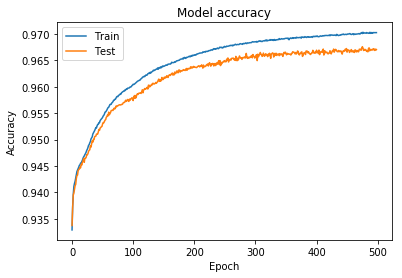

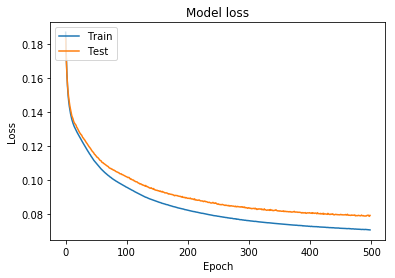

In [21]:
def plot_model(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plot_model(history)

Treinando por mais épocas, conseguimos um modelo que entende o conceito dos algarismos, mas consegue prever corretamente menos 5% deles. Esse parece ser o limite dessa arquitetura.

## Segunda Tentativa
Como um modelo pequeno não foi capaz de generalizar o problema, vamos criar um modelo mais profundo (10 camadas ocultas):

In [22]:
model2 = Sequential()
model2.add(Dense(units=128, activation='relu', input_dim=13))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
__________

In [23]:
evaluate_model(model2, df_test)

1000/1000 [==============================] - 0s 144us/step
Custo: 0.6930582513809204
Acurácia: 0.5088203125


In [24]:
df2_p0 = evaluate_algorisms(model2, df_test)
df2_p0.head()

0 acertos 0.0 %


,match,numero,pred,romano
0,False,3208,CLCLIVDIXIII LXX,MMMCCVIII
1,False,4994,CLCLILDIXIIM LXX,MMMMCMXCIV
2,False,3997,CLCLILDIXLII LIX,MMMCMXCVII
3,False,2573,CLCLIVDIXIIM CXX,MMDLXXIII
4,False,4184,CLCLIVDIXIXI VXX,MMMMCLXXXIV


In [25]:
history2 = model2.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=500, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/500
3599/3599 [==============================] - 1s 243us/step - loss: 0.2463 - acc: 0.9097 - val_loss: 0.1890 - val_acc: 0.9280
Epoch 2/500
3599/3599 [==============================] - 1s 140us/step - loss: 0.1845 - acc: 0.9296 - val_loss: 0.1873 - val_acc: 0.9280
Epoch 3/500
3599/3599 [==============================] - 1s 140us/step - loss: 0.1831 - acc: 0.9297 - val_loss: 0.1802 - val_acc: 0.9322
Epoch 4/500
3599/3599 [==============================] - 1s 139us/step - loss: 0.1490 - acc: 0.9392 - val_loss: 0.1443 - val_acc: 0.9398
Epoch 5/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.1358 - acc: 0.9416 - val_loss: 0.1349 - val_acc: 0.9413
Epoch 6/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.1316 - acc: 0.9431 - val_loss: 0.1308 - val_acc: 0.9437
Epoch 7/500
3599/3599 [==============================] - 1s 140us/step - loss: 0.1274 - acc: 0.9451 - val_loss: 0.1282 - val_acc: 0

3599/3599 [==============================] - 1s 140us/step - loss: 0.0575 - acc: 0.9740 - val_loss: 0.0722 - val_acc: 0.9688
Epoch 61/500
3599/3599 [==============================] - 1s 140us/step - loss: 0.0571 - acc: 0.9741 - val_loss: 0.0723 - val_acc: 0.9691
Epoch 62/500
3599/3599 [==============================] - 1s 140us/step - loss: 0.0583 - acc: 0.9735 - val_loss: 0.0690 - val_acc: 0.9712
Epoch 63/500
3599/3599 [==============================] - 1s 143us/step - loss: 0.0566 - acc: 0.9743 - val_loss: 0.0713 - val_acc: 0.9695
Epoch 64/500
3599/3599 [==============================] - 1s 144us/step - loss: 0.0562 - acc: 0.9746 - val_loss: 0.0690 - val_acc: 0.9703
Epoch 65/500
3599/3599 [==============================] - 1s 145us/step - loss: 0.0544 - acc: 0.9753 - val_loss: 0.0703 - val_acc: 0.9703
Epoch 66/500
3599/3599 [==============================] - 1s 167us/step - loss: 0.0546 - acc: 0.9751 - val_loss: 0.0741 - val_acc: 0.9672
Epoch 67/500
3599/3599 [=======================

3599/3599 [==============================] - 1s 142us/step - loss: 0.0430 - acc: 0.9801 - val_loss: 0.0665 - val_acc: 0.9725
Epoch 120/500
3599/3599 [==============================] - 1s 140us/step - loss: 0.0442 - acc: 0.9797 - val_loss: 0.0698 - val_acc: 0.9717
Epoch 121/500
3599/3599 [==============================] - 1s 144us/step - loss: 0.0458 - acc: 0.9790 - val_loss: 0.0657 - val_acc: 0.9724
Epoch 122/500
3599/3599 [==============================] - 1s 140us/step - loss: 0.0423 - acc: 0.9803 - val_loss: 0.0673 - val_acc: 0.9724
Epoch 123/500
3599/3599 [==============================] - 1s 145us/step - loss: 0.0425 - acc: 0.9804 - val_loss: 0.0695 - val_acc: 0.9710
Epoch 124/500
3599/3599 [==============================] - 1s 143us/step - loss: 0.0444 - acc: 0.9796 - val_loss: 0.0649 - val_acc: 0.9726
Epoch 125/500
3599/3599 [==============================] - 0s 139us/step - loss: 0.0428 - acc: 0.9800 - val_loss: 0.0663 - val_acc: 0.9727
Epoch 126/500
3599/3599 [================

3599/3599 [==============================] - 1s 140us/step - loss: 0.0353 - acc: 0.9840 - val_loss: 0.0818 - val_acc: 0.9696
Epoch 179/500
3599/3599 [==============================] - 1s 142us/step - loss: 0.0401 - acc: 0.9822 - val_loss: 0.0801 - val_acc: 0.9704
Epoch 180/500
3599/3599 [==============================] - 1s 142us/step - loss: 0.0376 - acc: 0.9832 - val_loss: 0.0782 - val_acc: 0.9721
Epoch 181/500
3599/3599 [==============================] - 1s 139us/step - loss: 0.0343 - acc: 0.9845 - val_loss: 0.0822 - val_acc: 0.9714
Epoch 182/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.0347 - acc: 0.9843 - val_loss: 0.0810 - val_acc: 0.9705
Epoch 183/500
3599/3599 [==============================] - 0s 139us/step - loss: 0.0343 - acc: 0.9845 - val_loss: 0.0825 - val_acc: 0.9704
Epoch 184/500
3599/3599 [==============================] - 1s 140us/step - loss: 0.0358 - acc: 0.9839 - val_loss: 0.0828 - val_acc: 0.9698
Epoch 185/500
3599/3599 [================

3599/3599 [==============================] - 1s 143us/step - loss: 0.0317 - acc: 0.9865 - val_loss: 0.1093 - val_acc: 0.9679
Epoch 238/500
3599/3599 [==============================] - 1s 142us/step - loss: 0.0281 - acc: 0.9880 - val_loss: 0.1063 - val_acc: 0.9698
Epoch 239/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.0355 - acc: 0.9855 - val_loss: 0.0953 - val_acc: 0.9700
Epoch 240/500
3599/3599 [==============================] - 0s 139us/step - loss: 0.0275 - acc: 0.9880 - val_loss: 0.1001 - val_acc: 0.9707
Epoch 241/500
3599/3599 [==============================] - 0s 138us/step - loss: 0.0238 - acc: 0.9895 - val_loss: 0.1063 - val_acc: 0.9712
Epoch 242/500
3599/3599 [==============================] - 1s 143us/step - loss: 0.0237 - acc: 0.9897 - val_loss: 0.1169 - val_acc: 0.9683
Epoch 243/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.0232 - acc: 0.9900 - val_loss: 0.1140 - val_acc: 0.9701
Epoch 244/500
3599/3599 [================

3599/3599 [==============================] - 1s 141us/step - loss: 0.0150 - acc: 0.9938 - val_loss: 0.1374 - val_acc: 0.9704
Epoch 297/500
3599/3599 [==============================] - 1s 139us/step - loss: 0.0145 - acc: 0.9940 - val_loss: 0.1387 - val_acc: 0.9706
Epoch 298/500
3599/3599 [==============================] - 1s 140us/step - loss: 0.0165 - acc: 0.9931 - val_loss: 0.1500 - val_acc: 0.9687
Epoch 299/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.0208 - acc: 0.9914 - val_loss: 0.1365 - val_acc: 0.9693
Epoch 300/500
3599/3599 [==============================] - 1s 142us/step - loss: 0.0308 - acc: 0.9882 - val_loss: 0.1444 - val_acc: 0.9654
Epoch 301/500
3599/3599 [==============================] - 1s 139us/step - loss: 0.0276 - acc: 0.9888 - val_loss: 0.1214 - val_acc: 0.9705
Epoch 302/500
3599/3599 [==============================] - 1s 142us/step - loss: 0.0174 - acc: 0.9928 - val_loss: 0.1306 - val_acc: 0.9705
Epoch 303/500
3599/3599 [================

3599/3599 [==============================] - 1s 142us/step - loss: 0.0110 - acc: 0.9957 - val_loss: 0.1791 - val_acc: 0.9689
Epoch 356/500
3599/3599 [==============================] - 1s 140us/step - loss: 0.0190 - acc: 0.9927 - val_loss: 0.1724 - val_acc: 0.9673
Epoch 357/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.0215 - acc: 0.9917 - val_loss: 0.1558 - val_acc: 0.9689
Epoch 358/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.0223 - acc: 0.9916 - val_loss: 0.1487 - val_acc: 0.9685
Epoch 359/500
3599/3599 [==============================] - 1s 143us/step - loss: 0.0177 - acc: 0.9931 - val_loss: 0.1515 - val_acc: 0.9684
Epoch 360/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.0129 - acc: 0.9948 - val_loss: 0.1594 - val_acc: 0.9697
Epoch 361/500
3599/3599 [==============================] - 0s 139us/step - loss: 0.0105 - acc: 0.9959 - val_loss: 0.1678 - val_acc: 0.9697
Epoch 362/500
3599/3599 [================

3599/3599 [==============================] - 1s 144us/step - loss: 0.0104 - acc: 0.9961 - val_loss: 0.1712 - val_acc: 0.9700
Epoch 415/500
3599/3599 [==============================] - 1s 142us/step - loss: 0.0069 - acc: 0.9976 - val_loss: 0.1871 - val_acc: 0.9702
Epoch 416/500
3599/3599 [==============================] - 1s 142us/step - loss: 0.0058 - acc: 0.9980 - val_loss: 0.1960 - val_acc: 0.9696
Epoch 417/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.0052 - acc: 0.9981 - val_loss: 0.1984 - val_acc: 0.9701
Epoch 418/500
3599/3599 [==============================] - 1s 143us/step - loss: 0.0043 - acc: 0.9986 - val_loss: 0.2096 - val_acc: 0.9703
Epoch 419/500
3599/3599 [==============================] - 1s 143us/step - loss: 0.0078 - acc: 0.9971 - val_loss: 0.2060 - val_acc: 0.9695
Epoch 420/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.0221 - acc: 0.9922 - val_loss: 0.1736 - val_acc: 0.9679
Epoch 421/500
3599/3599 [================

3599/3599 [==============================] - 1s 142us/step - loss: 0.0049 - acc: 0.9985 - val_loss: 0.1806 - val_acc: 0.9709
Epoch 474/500
3599/3599 [==============================] - 1s 143us/step - loss: 0.0035 - acc: 0.9990 - val_loss: 0.1953 - val_acc: 0.9698
Epoch 475/500
3599/3599 [==============================] - 1s 141us/step - loss: 0.0028 - acc: 0.9992 - val_loss: 0.2042 - val_acc: 0.9709
Epoch 476/500
3599/3599 [==============================] - 1s 142us/step - loss: 0.0027 - acc: 0.9992 - val_loss: 0.2112 - val_acc: 0.9705
Epoch 477/500
3599/3599 [==============================] - 1s 143us/step - loss: 0.0050 - acc: 0.9983 - val_loss: 0.2209 - val_acc: 0.9694
Epoch 478/500
3599/3599 [==============================] - 1s 144us/step - loss: 0.0203 - acc: 0.9932 - val_loss: 0.1796 - val_acc: 0.9676
Epoch 479/500
3599/3599 [==============================] - 1s 142us/step - loss: 0.0198 - acc: 0.9929 - val_loss: 0.1622 - val_acc: 0.9684
Epoch 480/500
3599/3599 [================

In [26]:
evaluate_model(model2, df_test)

1000/1000 [==============================] - 0s 35us/step
Custo: 0.19845810985565185
Acurácia: 0.971


In [27]:
df2_p500 = evaluate_algorisms(model2, df_test)
df2_p500.head()

74 acertos 7.4 %


,match,numero,pred,romano
0,False,3208,MMMCCIX,MMMCCVIII
1,False,4994,MMMMCMXCVI,MMMMCMXCIV
2,False,3997,MMMCMXCII,MMMCMXCVII
3,False,2573,MMDLXXII,MMDLXXIII
4,False,4184,MMMMCLXXXV,MMMMCLXXXIV


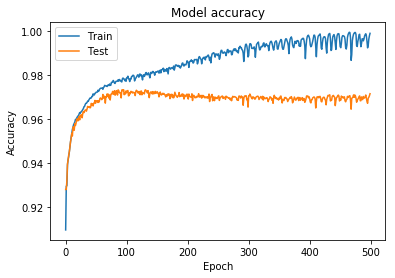

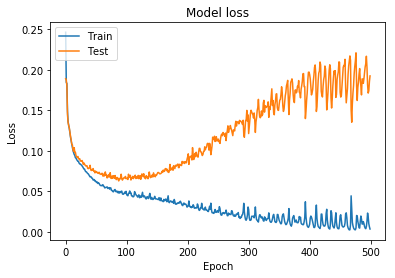

In [28]:
plot_model(history2)

#### Overfit!!
Dessa vez o modelo consegue acertar todo o conjunto de treino mas não o conjunto de testes, o modelo apenas decorou os algarismos do conjunto de treino mas não consegue generalizar o problema. Dizemos que esse modelo possui uma grande variância e está em regime de **overfit**.

## Terceira tentativa
Por último, vamos tentar uma rede com 4 camadas ocultas, mas com mais nós em cada camada para extrair mais características.

In [29]:
model3 = Sequential()
model3.add(Dense(units=1024, activation='relu', input_dim=13))
model3.add(Dense(units=512, activation='relu'))
model3.add(Dense(units=256, activation='relu'))
model3.add(Dense(units=128, activation='sigmoid'))
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              14336     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
Total params: 703,360
Trainable params: 703,360
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3 = model3.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=120, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/120
3599/3599 [==============================] - 1s 309us/step - loss: 0.2134 - acc: 0.9210 - val_loss: 0.1471 - val_acc: 0.9404
Epoch 2/120
3599/3599 [==============================] - 1s 213us/step - loss: 0.1342 - acc: 0.9449 - val_loss: 0.1305 - val_acc: 0.9467
Epoch 3/120
3599/3599 [==============================] - 1s 213us/step - loss: 0.1207 - acc: 0.9505 - val_loss: 0.1179 - val_acc: 0.9518
Epoch 4/120
3599/3599 [==============================] - 1s 210us/step - loss: 0.1105 - acc: 0.9543 - val_loss: 0.1095 - val_acc: 0.9542
Epoch 5/120
3599/3599 [==============================] - 1s 212us/step - loss: 0.1034 - acc: 0.9569 - val_loss: 0.1049 - val_acc: 0.9561
Epoch 6/120
3599/3599 [==============================] - 1s 210us/step - loss: 0.0987 - acc: 0.9586 - val_loss: 0.1004 - val_acc: 0.9573
Epoch 7/120
3599/3599 [==============================] - 1s 211us/step - loss: 0.0946 - acc: 0.9605 - val_loss: 0.0983 - val_acc: 0

In [ ]:
evaluate_model(model3, df_test)

In [ ]:
df3_p120 = evaluate_algorisms(model3, df_test)
df3_p120.head()

In [ ]:
plot_model(history3)

#### Certin!!!
Encontrar os parâmetros ótimos para cada problema é um processo iterativo e requer paciência e experiência.

## Importante
- Cada "neurônio" é muito simples (MatMul, Bias Add, ACTIVATE!);
- Backpropagation;
- Escolha da arquitetura e hiperparâmetros (camadas, ativações, otimizador);
- **Escolha do custo**;

In [ ]:
def predict(n):
    n_enc = encode_in(n)
    print("encode n: {}".format(n_enc))
    pred = model3.predict(np.array([n_enc]))
    print("pred enc_n: {}".format(pred.round(3).reshape((16, -1))))
    out = decode_out(pred)
    print("decode pred: {}".format(out))
    return out
predict(666)

## Shhhh 🤫 Último modelo

Conhecimento de domínio pode auxiliar muito no treinamento dos modelos. Sabendo que a base dos algorítmos romanos é decimal, podemos passar os dígitos de entrada com um `encoding` decimal:

In [ ]:
def encode_in(row):
    zeros = np.zeros((4, 10)).astype(np.uint8)
    R = [int(c) for c in str(row).zfill(4)]
    zeros[np.arange(4), R] = 1
    return zeros.flatten()

df["in"] = df["numero"].apply(encode_in)
df["in"].head()

In [ ]:
def decode_in(row):
    return int("".join([str(np.argmax(line)) for line in row.reshape(4, 10)]))

df["in"].apply(decode_in)
df["in"].apply(decode_in) == df["numero"]
all(df["in"].apply(decode_in) == df["numero"])

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.6)
df_train = df_train.reset_index().drop(columns="index")
df_test = df_test.reset_index().drop(columns="index")
print("treino:", len(df_train), "teste:", len(df_test))

In [ ]:
model4 = Sequential()
model4.add(Dense(units=64, activation='relu', input_dim=40))
model4.add(Dense(units=128, activation='sigmoid'))
model4.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.01
                             , beta_1=0.5, beta_2=0.9),
              metrics=['accuracy'])
model4.summary()

In [ ]:
history4 = model4.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=50, validation_split=0.1)

In [ ]:
evaluate_model(model4, df_test)

In [ ]:
df4_p50 = evaluate_algorisms(model4, df_test)
df4_p50.head()

In [ ]:
plot_model(history4)

## Conclusões
### - Algarismos Romanos + NN = EZ
### - ML is FUN kids